# Практическая работа: улучшение нейросети



В этом задании мы попробуем улучшить нейронную сеть, которую написали на практическом занятии. Работать мы будем все с тем же датасетом СIFAR10 и библиотекой PyTorch.

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

## Загрузка датасета


In [1]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [2]:
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle = False)

In [4]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [5]:
images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

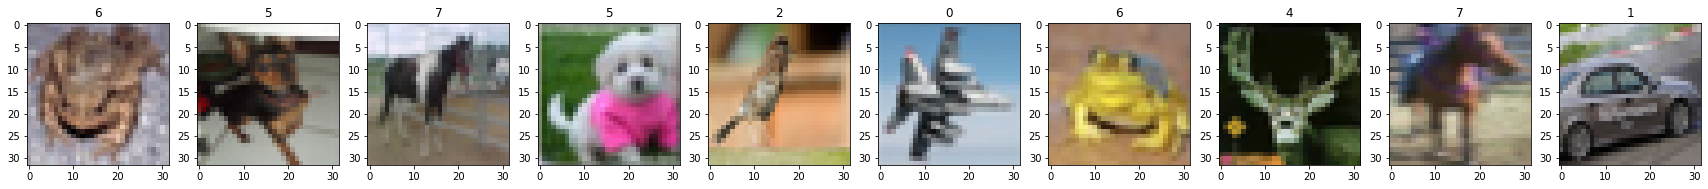

In [6]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)


Таблица соответствий номеров ответов и классов:

| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      | 
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [7]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}

Импортируем нужные модули для обучения сети:

In [8]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

## Обучение и тест базовой сети.

Для начала построим двуслойную нейронную сеть, как в практическом занятии, и посчитаем метрику accuracy на тестовой выборке:

<a href="https://ibb.co/prDn4RG"><img src="https://i.ibb.co/G3wFCtB/Screen-Shot-2020-03-14-at-9-43-10-PM.png" alt="Screen-Shot-2020-03-14-at-9-43-10-PM" border="0"></a>

In [26]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc2(x), dim = -1)
        return x

Давайте вынесем код обучения сети в отдельную функцию, чтобы каждый раз при изменении сети не копировать его. Код обучения мы менять не будем.

In [27]:
from tqdm.notebook import trange, tqdm
def train(net):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 2 эпохи
  for epoch in tqdm(range(2)): # tqdm_notebook

      running_loss = 0.0
      train_dataiter = iter(train_loader)
      for i, batch in enumerate(tqdm(train_dataiter)):  # tqdm_notebook
          # так получаем текущий батч
          X_batch, y_batch = batch
          
          # обнуляем веса
          optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
          y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
          loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
          loss.backward()
          # обновление весов сети
          optimizer.step()

          # выведем текущий loss
          running_loss += loss.item()
          # выведем качество каждые 500 батчей
          if i % 500 == 499:
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

  print('Обучение закончено')
  return net

In [28]:
# объявляем сеть
net = SimpleNN()
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net = train(net)

[1,   500] loss: 2.284
[1,  1000] loss: 2.201
[1,  1500] loss: 2.173
[1,  2000] loss: 2.166
[1,  2500] loss: 2.146
[1,  3000] loss: 2.144



[2,   500] loss: 2.139
[2,  1000] loss: 2.139
[2,  1500] loss: 2.130
[2,  2000] loss: 2.130
[2,  2500] loss: 2.127
[2,  3000] loss: 2.128


Обучение закончено


Посчитаем accuracy на test:

In [29]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [30]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.3308

# Задание: улучшение работы нейронной сети

## Часть 1. Обучение более глубокой сети

Наша двухслойная сеть не очень хорошо справляется с поставленной задачей. Давайте попробуем объявить и обучить более глубокую сеть -- трехслойную.

**Задание:**
Постройте нейронную сеть, содержащую три слоя. Первый  размерности 256, второй размерности 64, третий (выходной) -- размерности 10. 

В качестве примера смотрите на код с практического занятия, там мы строили двуслойную нейронную сеть с размерностями слоев 256 и 10.

In [31]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()

        self.fc1 = nn.Linear(32*32*3, 256) #<первый линейный слой размерности <размер вектора картинки>*256>
        self.fc2 = nn.Linear(256, 64) #<второй линейный слой размерности 256*64>. 
        self.fc3 = nn.Linear(64, 10) #<третий линейный слой размерности 64*10>
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.fc1(x)
        x = F.relu(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        x = F.relu(x)
        #x = <пропускаем х через третий линейный слой и активацию softmax>
        x = self.fc3(x)
        x = F.softmax(x, dim = -1)
        return x

In [32]:
# объявляем сеть
net = SimpleNN()

In [33]:
# не изменяйте эту ячейку!
# эта ячейка проверяет ваш код на правильность
# если при запуске ячейка выдает ошибку, то у вас в коде ошибка

assert len(net.state_dict().keys()) == 6, "Неверное количество слоев. Прочитайте задание еще раз."

fc1 = list(net.state_dict().keys())[0]
fc2 = list(net.state_dict().keys())[2]
fc3 = list(net.state_dict().keys())[4]

assert net.state_dict()[fc1].shape == (256, 3072), "Неверные размерности первого слоя. \
Должно быть размер вектора картинки * 256"
assert net.state_dict()[fc2].shape == (64, 256), "Неверные размерности второго слоя. \
Должно быть 256 * 64"
assert net.state_dict()[fc3].shape == (10, 64), "Неверные размерности третьего слоя. \
Должно быть 64 * 10"

In [34]:
net = train(net)

[1,   500] loss: 2.244
[1,  1000] loss: 2.183
[1,  1500] loss: 2.159
[1,  2000] loss: 2.153
[1,  2500] loss: 2.146
[1,  3000] loss: 2.147



[2,   500] loss: 2.119
[2,  1000] loss: 2.112
[2,  1500] loss: 2.118
[2,  2000] loss: 2.111
[2,  2500] loss: 2.110
[2,  3000] loss: 2.111


Обучение закончено


In [35]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [36]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.3459

Видим, что добавление еще одного слоя не особо помогло. Давайте попробуем улучшить сеть другими способами:

## Часть 2. BachNormalization

Одно из улучшений нейронной сети -- Батч Норм (BatchNorm). 

Смысл Батч Норма состоит в следующем: как вы знаете, когда мы обучаем нейронную сеть, мы обучаем ее батчами. Каждый батч картинок имеет разное распределение. Когда батч проходит через первый слой сети, выход первого слоя сети тоже имеет какое-то распределение. И для всех батчей оно немного разное. 

Таким образом, второй слой сети каждый раз принимает на вход данные, распределенные по-разному. И при обработке первого батча картинок веса сети подстраиваются под распределение картинок этого батча, а при обработке второго должны подстраиваться под другое распределение второго батча. Такое "метание" плохо сказывается на обучении сети, оно становится менее стабильным и в итоге сеть обучается хуже.

Батч норм -- это специальный слой сети, который используется после каждого слоя нейронной сети (кроме последнего). Он **нормализует** выходы слоев. Таким образом, следуюшему слою нейронной сети каждый раз передаются данные, распределенные примерно одинаково.

Чтобы лучше осознать полезность батч норма, можно вспомнить, что при изучении КНН мы говорили о том, что перед обучением модели признаки можно нормировать. Если есть два признака (например, возраст и доход), один из которых представлен десятками, а другой -- десятками тысяч, то для лучшего обучения модели их лучше привести к одному виду. Так и тут -- для лучшего обучения нейронной сети батчи лучше привести к одному виду.

Более подробно прочитать про батч норм можно тут: http://neerc.ifmo.ru/wiki/index.php?title=Batch-normalization

Напишем класс нейронной сети из трех слоев с батч нормализацией. За основу возьмем сеть, написанную выше: три слоя, 256, 64 и 10 нейронов в каждом.

**Задание**: реализуйте код нейронной сети с батч нормами. Допишите код в ячейке ниже в недостающих местах и запустите обучение сети.

In [37]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(32*32*3, 256) #<первый линейный слой размерности <размер вектора картинки>*256>
        self.bn1 = nn.BatchNorm1d(256) # задаем слой батч норма для выхода слоя сети с 256 нейронами
        self.fc2 = nn.Linear(256, 64) #<второй линейный слой размерности 256*64>.
        self.bn2 = nn.BatchNorm1d(64) # задаем слой батч норма для выхода слоя сети с 64 нейронами
        self.fc3 = nn.Linear(64, 10) #<третий линейный слой размерности 64*10>
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # применение слоев и батч нормов по очереди:
        #<пропустите х через все слои и активации: fc1-relu-bn1-fc2-relu-bn2-fc3-softmax>
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = <пропускаем х через третий линейный слой и активацию softmax>
        x = self.fc3(x)
        x = F.softmax(x, dim = -1)

        return x

In [38]:
# объявляем сеть
net = SimpleNN()

In [39]:
# не изменяйте эту ячейку!
# эта ячейка проверяет ваш код на правильность
# если при запуске ячейка выдает ошибку, то у вас в коде ошибка

assert len(net.state_dict().keys()) == 16, "Неверное количество слоев. \
Проверьте, что в вашей сети три слоя и два батч-норма после первого и второго слоя."

fc1 = list(net.state_dict().keys())[0]
fc2 = list(net.state_dict().keys())[7]
fc3 = list(net.state_dict().keys())[14]

assert net.state_dict()[fc1].shape == (256, 3072), "Неверные размерности первого слоя. \
Должно быть размер вектора картинки * 256"
assert net.state_dict()[fc2].shape == (64, 256), "Неверные размерности второго слоя. \
Должно быть 256 * 64"
assert net.state_dict()[fc3].shape == (10, 64), "Неверные размерности третьего слоя. \
Должно быть 64 * 10"

Обучаем:

In [40]:
net = train(net)

[1,   500] loss: 2.180
[1,  1000] loss: 2.131
[1,  1500] loss: 2.120
[1,  2000] loss: 2.108
[1,  2500] loss: 2.108
[1,  3000] loss: 2.104



[2,   500] loss: 2.083
[2,  1000] loss: 2.086
[2,  1500] loss: 2.087
[2,  2000] loss: 2.082
[2,  2500] loss: 2.068
[2,  3000] loss: 2.074


Обучение закончено


In [41]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [42]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.4038

Видим, что accuracy увеличился! Batch Norm действительно работает.

## Часть 3.

Наверное, вы уже заметили, что у нас в модели довольно много гиперпараметров. Например: количество слоев, размеры каждого слоя, learning rate в градиентном спуске. Как и в не нейронных моделях машинного обучения, эти гиперпараметры можно подбирать. Этим мы сейчас и займемся.

Перенесем сюда код класса нейронной сети и функции обучения.

**Задание**: проведите несколько экспериментов (минимум 3) обучения сети с разными параметрами. Варьируйте количество слоев, количество нейронов в слоях (у нас выше были 256 и 64, попробуйте других числа), различные функции активации после внутренних слоев (после последнего оставьте softmax) и разный learning rate. Опишите свои выводы на основе проделанных экспериментов в отдельной ячейке ниже.

**P.S.** разные функции активации, как и relu, можно найти в torch.functional, который у нас импортирован как F.

In [ ]:
# примеры функций активации
F.relu
F.celu
F.elu
F.leaky_relu
F.prelu

#### Выводы

Опишите ваши выводы на основе проделанных экспериментов тут. Как повляили различные значения гиперпараметров на итоговую величиную accuracy? Как вы думаете, почему?

**Попробуем (1) добавить ещё один слой в 64 нейрона; затем (2) изменим функцию активации в нём на F.leaky_relu; далее, (3) изменим learning rate на 0.01**

## Эксперимент (1)

In [43]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(32*32*3, 256) #<первый линейный слой размерности <размер вектора картинки>*256>
        self.bn1 = nn.BatchNorm1d(256) # задаем слой батч норма для выхода слоя сети с 256 нейронами
        self.fc2 = nn.Linear(256, 64) #<второй линейный слой размерности 256*64>.
        self.bn2 = nn.BatchNorm1d(64) # задаем слой батч норма для выхода слоя сети с 64 нейронами
        self.fc3 = nn.Linear(64, 64) 
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10) #<финальный линейный слой размерности 64*10>
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # применение слоев и батч нормов по очереди:
        #<пропустите х через все слои и активации: fc1-relu-bn1-fc2-relu-bn2-fc3-softmax>
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = <пропускаем х через третий линейный слой и активацию >
        x = self.fc3(x)
        x = F.relu(x)
        x = self.bn3(x)
        
        x = self.fc4(x)
        x = F.softmax(x, dim = -1)

        return x

In [45]:
from tqdm.notebook import trange, tqdm
def train(net):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 2 эпохи
  for epoch in tqdm(range(2)): # tqdm_notebook

      running_loss = 0.0
      train_dataiter = iter(train_loader)
      for i, batch in enumerate(tqdm(train_dataiter)):  # tqdm_notebook
          # так получаем текущий батч
          X_batch, y_batch = batch
          
          # обнуляем веса
          optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
          y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
          loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
          loss.backward()
          # обновление весов сети
          optimizer.step()

          # выведем текущий loss
          running_loss += loss.item()
          # выведем качество каждые 500 батчей
          if i % 500 == 499:
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

  print('Обучение закончено')
  return net

In [46]:
net = SimpleNN()
net = train(net)

[1,   500] loss: 2.177
[1,  1000] loss: 2.129
[1,  1500] loss: 2.134
[1,  2000] loss: 2.131
[1,  2500] loss: 2.109
[1,  3000] loss: 2.109



[2,   500] loss: 2.099
[2,  1000] loss: 2.091
[2,  1500] loss: 2.095
[2,  2000] loss: 2.091
[2,  2500] loss: 2.096
[2,  3000] loss: 2.085


Обучение закончено


In [47]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [48]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.405

## Эксперимент (2)

In [49]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(32*32*3, 256) #<первый линейный слой размерности <размер вектора картинки>*256>
        self.bn1 = nn.BatchNorm1d(256) # задаем слой батч норма для выхода слоя сети с 256 нейронами
        self.fc2 = nn.Linear(256, 64) #<второй линейный слой размерности 256*64>.
        self.bn2 = nn.BatchNorm1d(64) # задаем слой батч норма для выхода слоя сети с 64 нейронами
        self.fc3 = nn.Linear(64, 64) 
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10) #<финальный линейный слой размерности 64*10>
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # применение слоев и батч нормов по очереди:
        #<пропустите х через все слои и активации: fc1-relu-bn1-fc2-relu-bn2-fc3-softmax>
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = <пропускаем х через третий линейный слой и активацию >
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.bn3(x)
        
        x = self.fc4(x)
        x = F.softmax(x, dim = -1)

        return x

In [50]:
from tqdm.notebook import trange, tqdm
def train(net):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 2 эпохи
  for epoch in tqdm(range(2)): # tqdm_notebook

      running_loss = 0.0
      train_dataiter = iter(train_loader)
      for i, batch in enumerate(tqdm(train_dataiter)):  # tqdm_notebook
          # так получаем текущий батч
          X_batch, y_batch = batch
          
          # обнуляем веса
          optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
          y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
          loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
          loss.backward()
          # обновление весов сети
          optimizer.step()

          # выведем текущий loss
          running_loss += loss.item()
          # выведем качество каждые 500 батчей
          if i % 500 == 499:
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

  print('Обучение закончено')
  return net

In [51]:
net = SimpleNN()
net = train(net)

[1,   500] loss: 2.181
[1,  1000] loss: 2.130
[1,  1500] loss: 2.131
[1,  2000] loss: 2.118
[1,  2500] loss: 2.113
[1,  3000] loss: 2.110



[2,   500] loss: 2.095
[2,  1000] loss: 2.093
[2,  1500] loss: 2.085
[2,  2000] loss: 2.089
[2,  2500] loss: 2.090
[2,  3000] loss: 2.086


Обучение закончено


In [52]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [53]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.399

## Эксперимент (3)

In [54]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(32*32*3, 256) #<первый линейный слой размерности <размер вектора картинки>*256>
        self.bn1 = nn.BatchNorm1d(256) # задаем слой батч норма для выхода слоя сети с 256 нейронами
        self.fc2 = nn.Linear(256, 64) #<второй линейный слой размерности 256*64>.
        self.bn2 = nn.BatchNorm1d(64) # задаем слой батч норма для выхода слоя сети с 64 нейронами
        self.fc3 = nn.Linear(64, 64) 
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10) #<финальный линейный слой размерности 64*10>
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # применение слоев и батч нормов по очереди:
        #<пропустите х через все слои и активации: fc1-relu-bn1-fc2-relu-bn2-fc3-softmax>
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = <пропускаем х через третий линейный слой и активацию >
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.bn3(x)
        
        x = self.fc4(x)
        x = F.softmax(x, dim = -1)

        return x

In [55]:
from tqdm.notebook import trange, tqdm
def train(net):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 0.01
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 2 эпохи
  for epoch in tqdm(range(2)): # tqdm_notebook

      running_loss = 0.0
      train_dataiter = iter(train_loader)
      for i, batch in enumerate(tqdm(train_dataiter)):  # tqdm_notebook
          # так получаем текущий батч
          X_batch, y_batch = batch
          
          # обнуляем веса
          optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
          y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
          loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
          loss.backward()
          # обновление весов сети
          optimizer.step()

          # выведем текущий loss
          running_loss += loss.item()
          # выведем качество каждые 500 батчей
          if i % 500 == 499:
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

  print('Обучение закончено')
  return net

In [56]:
net = SimpleNN()
net = train(net)

[1,   500] loss: 2.213
[1,  1000] loss: 2.190
[1,  1500] loss: 2.178
[1,  2000] loss: 2.167
[1,  2500] loss: 2.157
[1,  3000] loss: 2.160



[2,   500] loss: 2.156
[2,  1000] loss: 2.136
[2,  1500] loss: 2.145
[2,  2000] loss: 2.157
[2,  2500] loss: 2.147
[2,  3000] loss: 2.149


Обучение закончено


In [57]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [58]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.3101

#### Выводы

Опишите ваши выводы на основе проделанных экспериментов тут. Как повляили различные значения гиперпараметров на итоговую величиную accuracy? Как вы думаете, почему?

**Итак, точность по результатам экспериментов:**
- исходная точность - 0.4038
- (1) добавление слоя 64 нейрона - 0.405
- (2) изменение в нём функции на leaky_relu - 0.399
- (3) изменение learning_rate = 0.01 - 0.3101


Можно заметить, что положительный вклад в точность имеет добавление ещё одного слоя нейронов - это повышает чувствительность сети.